In [1]:
import torch
import random
import numpy as np
import pandas as pd
import torch.utils.data as data
from tqdm.notebook import tqdm
import torch.nn as nn
import wandb

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kubuseg. Use `wandb login --relogin` to force relogin


True

In [3]:
torch.cuda.set_device(0)
device = torch.device("cuda")
torch.cuda.get_device_name(0)

'NVIDIA RTX A3000 12GB Laptop GPU'

In [4]:
random.seed(0)  # python random generator
np.random.seed(0)  # numpy random generator

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
LEARNING_RATE = 1e-4
EPOCHS = 150
MODEL = "J-CNN"
DATASET_NAME = "ntu60"  # (ntu60, ntu120)
SKELETON_TYPE = "2D"  # (2D, 3D)
EVAL_TYPE = "xview"  # (xsub, xview, xset)
SAMPLING = "even_spaced"  # (even_spaced, uniform)
OUT_FRAME_NUM = 30
BATCH_SIZE = 128
SCHEDULER = "ReduceLROnPlateau"  # (ReduceLROnPlateau, ExponentialLR)
SCHEDULER_GAMMA = 0.975
SCHEDULER_MIN_LR = 1e-7
SCHEDULER_PATIENCE = 10
DROPOUT_CONV = 0.15
DROPOUT_FF = 0.75

In [6]:
POSE_MODEL, COORDINATE_DIM, JOINT_NUMBER, ORIGIN_JOINTS = (
    ("hrnet", 2, 17, [5, 6, 11, 12])
    if SKELETON_TYPE == "2D"
    else ("3danno", 3, 25, [1])
)
DATASET_PATH = DATASET_NAME + "_" + POSE_MODEL + ".pkl"
CLASS_NUMBER = 60 if DATASET_NAME == "ntu60" else 120

### Load and preprocess data

In [7]:
dataset = np.load(DATASET_PATH, allow_pickle=True)

In [8]:
def interpolateMissingFrames(movie):
    """
    Interpolate joint vals based on last valid value,
    number of invalid frames and current valid frame

    :param movie: has shape [Frame, Person, Axis, Joint]
    """
    last_val_joint, last_val_frame = (
        np.zeros_like(movie[0]),
        np.zeros_like(movie[0]),
    )
    for idx, frame in enumerate(movie):
        # Array that counts frames since last valid frame
        val_frame_diff = idx - last_val_frame
        interp_cond = (frame != 0) & (val_frame_diff > 1) & (last_val_joint != 0)
        # Iterate over (Person, Axis, Joint) tuples for interpolation
        for index in np.transpose(interp_cond.nonzero()):
            index = tuple(index)
            # index - 3 item tuple (Person, Axis, Joint)
            last_frame, num_frames = (
                int(last_val_frame[index]),
                int(val_frame_diff[index]),
            )
            delta = (frame[index] - last_val_joint[index]) / val_frame_diff[index]
            for fr_num in range(1, num_frames):
                movie[(last_frame + fr_num,) + index] = (
                    last_val_joint[index] + delta * fr_num
                )
        last_val_joint[frame != 0] = frame[frame != 0]
        last_val_frame[frame != 0] = idx

In [9]:
def fillBorderFrames(movie):
    """
    Fill first n invalid joint values frames with first valid

    :param movie: has shape [Person, Axis, Frame, Joint]

    """
    is_joint_valid = movie[0] != 0
    for idx, frame in enumerate(movie[1:], start=1):
        if is_joint_valid.all():
            break
        fill_cond = (frame != 0) & (is_joint_valid == False)
        for index in np.transpose(fill_cond.nonzero()):
            index = tuple(index)
            for fr_num in range(0, idx):
                movie[(fr_num,) + index] = frame[index]
        is_joint_valid[frame != 0] = True

In [10]:
def handleMissingFrames(movie):
    if (movie == 0).sum() == 0:
        return
    # Movie shape: (Frame[x], Person[2], Axis[3], Joint[25])
    interpolateMissingFrames(movie=movie)
    # Backward fill
    fillBorderFrames(movie=movie)
    # Forward fill
    fillBorderFrames(movie=movie[::-1])

In [11]:
def evenSpacedSampling(movie, frame_num):
    num_frames = movie.shape[2]
    if num_frames <= frame_num:
        return movie
    indexes = np.linspace(
        start=0, stop=num_frames, num=frame_num, endpoint=False, dtype=np.int16
    )
    return movie[:, :, indexes]

In [12]:
def uniformSampling(movie, out_frame_num):
    movie_out = np.zeros(
        (movie.shape[0], movie.shape[1], out_frame_num, movie.shape[-1])
    )
    movie_frame_num = movie.shape[2]
    if movie_frame_num <= out_frame_num:
        movie_out[..., :movie_frame_num, :] = movie
        return movie_out
    for frame_idx, frame_group in enumerate(
        np.array_split(movie, out_frame_num, axis=2)
    ):
        frames = frame_group.shape[2]
        frame_taken = np.random.randint(0, frames)
        movie_out[..., frame_idx, :] = frame_group[..., frame_taken, :]
    return movie_out

In [13]:
def normalize(movie, origin_joints):
    # Change origin to joint val from first val frame
    origin = movie[..., 0, origin_joints].mean(axis=2)
    for frame_idx in range(1, movie.shape[2]):
        if (movie[..., frame_idx, origin_joints] != 0).all():
            origin = movie[..., frame_idx, origin_joints].mean(axis=2)
            break
    movie = (movie.reshape((-1, movie.shape[0], COORDINATE_DIM)) - origin).reshape(
        movie.shape
    )

    # for person_idx in range(movie.shape[0]):
    for axis_idx in range(movie.shape[1]):
        # for joint_idx in range(movie.shape[-1]):
        joint_keypoints = movie[:, axis_idx, :, :]
        movie[:, axis_idx, :, :] = (
            joint_keypoints - joint_keypoints.mean()
        ) / joint_keypoints.std()
    return movie

In [14]:
out_frame_num = OUT_FRAME_NUM
dataset_len = len(dataset["annotations"])
labels, names = [], []
skelets = torch.zeros(
    (dataset_len, 2, COORDINATE_DIM, out_frame_num, JOINT_NUMBER), dtype=torch.float32
)
for idx, anot in enumerate(tqdm(dataset["annotations"])):
    labels.append(anot["label"])
    names.append(anot["frame_dir"])
    movie = anot["keypoint"].astype(np.float32)

    movie = movie.transpose((0, 3, 1, 2))
    # Keypoint shape - (Person[2], Axis[3], Frame[x], Joint[25])
    handleMissingFrames(movie=movie.transpose((2, 0, 1, 3)))
    movie = (
        evenSpacedSampling(movie, out_frame_num)
        if SAMPLING == "even_spaced"
        else uniformSampling(movie, out_frame_num)
    )
    movie = normalize(movie, ORIGIN_JOINTS)

    skelets[idx, : movie.shape[0], :,
            : movie.shape[2]] = torch.from_numpy(movie)
labels = np.array(labels)
names = np.array(names)

  0%|          | 0/56578 [00:00<?, ?it/s]

In [15]:
zero_frame = torch.zeros(
    (skelets.shape[0], skelets.shape[1],
     skelets.shape[2], 1, skelets.shape[-1])
)

motion = torch.diff(skelets, axis=-2, prepend=zero_frame)

In [16]:
is_train = np.isin(names, np.array(dataset["split"][EVAL_TYPE + "_train"]))
is_val = np.isin(names, np.array(dataset["split"][EVAL_TYPE + "_val"]))

train_dataset = torch.utils.data.TensorDataset(
    skelets[is_train],
    motion[is_train],
    torch.from_numpy(labels[is_train]).type(torch.LongTensor),
)


val_dataset = torch.utils.data.TensorDataset(
    skelets[is_val],
    motion[is_val],
    torch.from_numpy(labels[is_val]).type(torch.LongTensor),
)

In [17]:
g = torch.Generator()
g.manual_seed(0)

batch_size = BATCH_SIZE
train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    generator=g,
)
val_loader = data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    generator=g,
)

### Build networks and prepare for training

In [18]:
class Block(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel=3, padding=1, groups=1, max_pool=False
    ):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel, padding=padding, groups=groups
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout2d(DROPOUT_CONV),
        )
        if max_pool:
            self.conv += nn.Sequential(
                nn.MaxPool2d(2),
            )

    def forward(self, x):
        x = self.conv(x)
        return x

In [19]:
folder_str = "models/" + DATASET_NAME + "/" + EVAL_TYPE + "/"


def fileName(accuracy, net_name):
    return (
        folder_str
        + net_name
        + "_"
        + SKELETON_TYPE
        + "_"
        + f"{accuracy:.1f}".replace(".", "")
        + ".pt"
    )

In [20]:
LOADED_ACC = 79.5

In [21]:
class NetConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            Block(
                COORDINATE_DIM,
                36,
                kernel=(COORDINATE_DIM, 1),
                padding=0,
                groups=COORDINATE_DIM,
            ),
            Block(36, 36, kernel=(COORDINATE_DIM, 1), padding=0),
        )
        self.conv2 = nn.Sequential(
            Block(36, 64, kernel=3, padding=1, max_pool=True),
            Block(64, 128, kernel=3, padding=1, max_pool=True),
        )

    def forward(self, x):
        # x = torch.transpose(x, 2, -1)
        # print("NetConv")
        # print(f"0:{x[:, 0].shape}")
        x0 = self.conv1(x[:, 0])
        x1 = self.conv1(x[:, 1])
        # x0 = torch.transpose(x0, -1, 1)
        # x1 = torch.transpose(x1, -1, 1)
        # print(f"1:{x0.shape}")
        x0 = self.conv2(x0)
        x1 = self.conv2(x1)
        # print(f"2:{x0.shape}")
        return x0, x1


net_raw = NetConv().to(device)

net_motion = NetConv().to(device)

# net_raw.load_state_dict(torch.load(fileName(LOADED_ACC, 'net_raw')))

# net_motion.load_state_dict(torch.load(fileName(LOADED_ACC, 'net_motion')))

In [22]:
class NetConv2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            Block(128, 256, kernel=3, padding=1, max_pool=True),
            Block(256, 512, kernel=3, padding=1, max_pool=True),
        )
        self.flatten = nn.Flatten()

    def forward(self, net_raw_1, net_raw_2, net_motion_1=None, net_motion_2=None):
        if net_motion_1:
            x0 = torch.cat((net_raw_1, net_motion_1), dim=1)
            x1 = torch.cat((net_raw_2, net_motion_2), dim=1)
        else:
            x0 = net_raw_1
            x1 = net_raw_2
        # print("NetConv2")
        # print(f"0:{x0.shape}")
        x0 = self.conv(x0)
        x1 = self.conv(x1)
        # print(f"1:{x0.shape}")
        x = torch.maximum(self.flatten(x0), self.flatten(x1))
        return x


net_conv_2 = NetConv2().to(device)

# net_conv_2.load_state_dict(torch.load(fileName(LOADED_ACC, 'net_conv_2')))

In [23]:
class NetFF(nn.Module):
    def __init__(self):
        super().__init__()

        self.ff = nn.Sequential(
            # Linear 1
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(DROPOUT_FF),
            # Linear 2
            nn.Linear(256, CLASS_NUMBER),
        )

    def forward(self, x):
        x = self.ff(x)
        return x


net_ff = NetFF().to(device)
# net_ff.load_state_dict(torch.load(fileName(LOADED_ACC, 'net_ff')))
# net_ff

In [24]:
params = (
    sum(p.numel() for p in net_raw.parameters() if p.requires_grad)
    + sum(p.numel() for p in net_motion.parameters() if p.requires_grad)
    + sum(p.numel() for p in net_ff.parameters() if p.requires_grad)
    + sum(p.numel() for p in net_conv_2.parameters() if p.requires_grad)
)

print(f"Model parameters: {params:,}")

Model parameters: 1,819,964


In [25]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
params = (
    list(net_raw.parameters())
    + list(net_motion.parameters())
    + list(net_conv_2.parameters())
    + list(net_ff.parameters())
)
optimizer = optim.Adam(params, lr=LEARNING_RATE)
if SCHEDULER == "ReduceLROnPlateau":
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=0.5,
        patience=SCHEDULER_PATIENCE,
        min_lr=SCHEDULER_MIN_LR,
        verbose=True,
    )
else:
    scheduler = optim.lr_scheduler.ExponentialLR(
        optimizer, gamma=SCHEDULER_GAMMA)

In [26]:
def getAccuarcy(loader):
    correct, total = 0, 0
    net_raw.eval()

    net_motion.eval()
    net_conv_2.eval()

    net_ff.eval()

    with torch.no_grad():
        for raw, motion, labels in loader:
            raw, motion, labels = raw.to(device), motion.to(
                device), labels.to(device)

            raw_out_1, raw_out_2 = net_raw(raw)
            out_conv = net_conv_2(raw_out_1, raw_out_2)
            outputs = net_ff(out_conv)

            # the class with the highest energy is what we choose as prediction

            _, predicted = torch.max(outputs.data, dim=1)

            total += labels.size(0)

            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [27]:
from pathlib import Path
import os

net_dict = {
    "net_raw": net_raw,
    # "net_motion": net_motion,
    "net_conv_2": net_conv_2,
    "net_ff": net_ff,
}


def saveModels(accuracy):
    Path(folder_str).mkdir(parents=True, exist_ok=True)
    for net_name, net in net_dict.items():
        torch.save(net.state_dict(), fileName(accuracy, net_name))


def deleteModels(accuracy):
    for net_name in net_dict.keys():
        file_name = fileName(accuracy, net_name)
        if os.path.isfile(file_name):
            os.remove(file_name)

### Train network

In [28]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Inżynierka",
    # track hyperparameters and run metadata
    config={
        "learning_rate": LEARNING_RATE,
        "architecture": "CNN",
        "skeleton_type": SKELETON_TYPE,
        "eval_Type": EVAL_TYPE,
        "dataset": DATASET_NAME,
        "epochs": EPOCHS,
        "sampling": SAMPLING,
        "out_frame_num": OUT_FRAME_NUM,
        "batch_size": BATCH_SIZE,
        "scheduler": SCHEDULER,
        "optimizer": "adam",
        "dropout_conv": {"value": DROPOUT_CONV},
        "dropout_ff": {"value": DROPOUT_FF},
        "scheduler_min_lr": SCHEDULER_MIN_LR,
        "scheduler_patience": SCHEDULER_PATIENCE,
        "scheduler_gamma": SCHEDULER_GAMMA,
        "model": MODEL,
    },
)

In [29]:
iters = EPOCHS
best_acc = 0.0

for epoch in tqdm(range(iters)):
    net_raw.train()
    net_motion.train()
    net_conv_2.train()
    net_ff.train()
    running_loss = 0.0
    correct, total = 0, 0
    for i, (raw, motion, labels) in enumerate(train_loader):
        raw, motion, labels = raw.to(device), motion.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        raw_out_1, raw_out_2 = net_raw(raw)
        out_conv = net_conv_2(raw_out_1, raw_out_2)
        outputs = net_ff(out_conv)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print("[%d/%d] loss: %.1f" % (epoch + 1, iters, running_loss))
    print("Training acc: %.3f %%" % (100 * correct / total))
    acc = getAccuarcy(val_loader)
    print("Validation acc: %.3f %%" % acc)
    if SCHEDULER == "ReduceLROnPlateau":
        scheduler.step(acc)
    else:
        scheduler.step()
    if acc > best_acc:
        deleteModels(best_acc)
        best_acc = acc
        saveModels(best_acc)
    metrics = {
        "train/train_loss": running_loss,
        "train/epoch": epoch + 1,
        "train/train_accuracy": 100 * correct / total,
    }
    val_metrics = {"val/val_accuracy": acc, "val/val_max_accuracy": best_acc}
    wandb.log({**metrics, **val_metrics})
print("Finished Training")
print(f"Best acc: {best_acc:.3f}")
wandb.finish()

  0%|          | 0/150 [00:00<?, ?it/s]

[1/150] loss: 1164.5
Training acc: 4.593 %
Validation acc: 8.932 %
[2/150] loss: 1060.8
Training acc: 8.527 %
Validation acc: 15.149 %
[3/150] loss: 954.8
Training acc: 14.036 %
Validation acc: 23.262 %
[4/150] loss: 837.2
Training acc: 21.495 %
Validation acc: 33.383 %
[5/150] loss: 732.1
Training acc: 29.520 %
Validation acc: 41.121 %
[6/150] loss: 652.5
Training acc: 35.924 %
Validation acc: 51.859 %
[7/150] loss: 593.7
Training acc: 40.562 %
Validation acc: 56.011 %
[8/150] loss: 547.8
Training acc: 44.578 %
Validation acc: 58.504 %
[9/150] loss: 507.9
Training acc: 48.050 %
Validation acc: 61.562 %
[10/150] loss: 475.4
Training acc: 51.166 %
Validation acc: 64.024 %
[11/150] loss: 444.4
Training acc: 54.255 %
Validation acc: 66.190 %
[12/150] loss: 422.8
Training acc: 55.958 %
Validation acc: 66.300 %
[13/150] loss: 400.7
Training acc: 58.346 %
Validation acc: 71.044 %
[14/150] loss: 380.4
Training acc: 60.277 %
Validation acc: 71.725 %
[15/150] loss: 362.0
Training acc: 62.442 %


train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/train_accuracy,▁▂▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
train/train_loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_accuracy,▁▃▅▆▆▇▇▇▇▇▇▇▇▇██████████████████████████
val/val_max_accuracy,▁▃▅▆▆▇▇▇▇▇▇▇▇▇██████████████████████████
train/epoch,150
train/train_accuracy,94.13484
train/train_loss,51.36898
val/val_accuracy,91.80752
val/val_max_accuracy,91.96598


In [30]:
getAccuarcy(val_loader)

91.80752165645468

### Visualize results

#### Classes dict

In [31]:
class_dict = {
    "A1": "drink water",
    "A2": "eat meal",
    "A3": "brush teeth",
    "A4": "brush hair",
    "A5": "drop",
    "A6": "pick up",
    "A7": "throw",
    "A8": "sit down",
    "A9": "stand up",
    "A10": "clapping",
    "A11": "reading",
    "A12": "writing",
    "A13": "tear up paper",
    "A14": "put on jacket",
    "A15": "take off jacket",
    "A16": "put on a shoe",
    "A17": "take off a shoe",
    "A18": "put on glasses",
    "A19": "take off glasses",
    "A20": "put on a hat/cap",
    "A21": "take off a hat/cap",
    "A22": "cheer up",
    "A23": "hand waving",
    "A24": "kicking something",
    "A25": "reach into pocket",
    "A26": "hopping",
    "A27": "jump up",
    "A28": "phone call",
    "A29": "play with phone/tablet",
    "A30": "type on a keyboard",
    "A31": "point to something",
    "A32": "taking a selfie",
    "A33": "check time (from watch)",
    "A34": "rub two hands",
    "A35": "nod head/bow",
    "A36": "shake head",
    "A37": "wipe face",
    "A38": "salute",
    "A39": "put palms together",
    "A40": "cross hands in front",
    "A41": "sneeze/cough",
    "A42": "staggering",
    "A43": "falling down",
    "A44": "headache",
    "A45": "chest pain",
    "A46": "back pain",
    "A47": "neck pain",
    "A48": "nausea/vomiting",
    "A49": "fan self",
    "A50": "punch/slap",
    "A51": "kicking",
    "A52": "pushing",
    "A53": "pat on back",
    "A54": "point finger",
    "A55": "hugging",
    "A56": "giving object",
    "A57": "touch pocket",
    "A58": "shaking hands",
    "A59": "walking towards",
    "A60": "walking apart",
    "A61": "put on headphone",
    "A62": "take off headphone",
    "A63": "shoot at basket",
    "A64": "bounce ball",
    "A65": "tennis bat swing",
    "A66": "juggle table tennis ball",
    "A67": "hush",
    "A68": "flick hair",
    "A69": "thumb up",
    "A70": "thumb down",
    "A71": "make OK sign",
    "A72": "make victory sign",
    "A73": "staple book",
    "A74": "counting money",
    "A75": "cutting nails",
    "A76": "cutting paper",
    "A77": "snap fingers",
    "A78": "open bottle",
    "A79": "sniff/smell",
    "A80": "squat down",
    "A81": "toss a coin",
    "A82": "fold paper",
    "A83": "ball up paper",
    "A84": "play magic cube",
    "A85": "apply cream on face",
    "A86": "apply cream on hand",
    "A87": "put on bag",
    "A88": "take off bag",
    "A89": "put object into bag",
    "A90": "take object out of bag",
    "A91": "open a box",
    "A92": "move heavy objects",
    "A93": "shake fist",
    "A94": "throw up cap/hat",
    "A95": "capitulate",
    "A96": "cross arms",
    "A97": "arm circles",
    "A98": "arm swings",
    "A99": "run on the spot",
    "A100": "butt kicks",
    "A101": "cross toe touch",
    "A102": "side kick",
    "A103": "yawn",
    "A104": "stretch oneself",
    "A105": "blow nose",
    "A106": "hit with object",
    "A107": "wield knife",
    "A108": "knock over",
    "A109": "grab stuff",
    "A110": "shoot with gun",
    "A111": "step on foot",
    "A112": "high-five",
    "A113": "cheers and drink",
    "A114": "carry object",
    "A115": "take a photo",
    "A116": "follow",
    "A117": "whisper",
    "A118": "exchange things",
    "A119": "support somebody",
    "A120": "rock-paper-scissors",
}

In [32]:
daily_actions = {
    "A1": "drink water",
    "A2": "eat meal",
    "A3": "brush teeth",
    "A4": "brush hair",
    "A5": "drop",
    "A6": "pick up",
    "A7": "throw",
    "A8": "sit down",
    "A9": "stand up",
    "A10": "clapping",
    "A11": "reading",
    "A12": "writing",
    "A13": "tear up paper",
    "A14": "put on jacket",
    "A15": "take off jacket",
    "A16": "put on a shoe",
    "A17": "take off a shoe",
    "A18": "put on glasses",
    "A19": "take off glasses",
    "A20": "put on a hat/cap",
    "A21": "take off a hat/cap",
    "A22": "cheer up",
    "A23": "hand waving",
    "A24": "kicking something",
    "A25": "reach into pocket",
    "A26": "hopping",
    "A27": "jump up",
    "A28": "phone call",
    "A29": "play with phone/tablet",
    "A30": "type on a keyboard",
    "A31": "point to something",
    "A32": "taking a selfie",
    "A33": "check time (from watch)",
    "A34": "rub two hands",
    "A35": "nod head/bow",
    "A36": "shake head",
    "A37": "wipe face",
    "A38": "salute",
    "A39": "put palms together",
    "A40": "cross hands in front",
    "A61": "put on headphone",
    "A62": "take off headphone",
    "A63": "shoot at basket",
    "A64": "bounce ball",
    "A65": "tennis bat swing",
    "A66": "juggle table tennis ball",
    "A67": "hush",
    "A68": "flick hair",
    "A69": "thumb up",
    "A70": "thumb down",
    "A71": "make OK sign",
    "A72": "make victory sign",
    "A73": "staple book",
    "A74": "counting money",
    "A75": "cutting nails",
    "A76": "cutting paper",
    "A77": "snap fingers",
    "A78": "open bottle",
    "A79": "sniff/smell",
    "A80": "squat down",
    "A81": "toss a coin",
    "A82": "fold paper",
    "A83": "ball up paper",
    "A84": "play magic cube",
    "A85": "apply cream on face",
    "A86": "apply cream on hand",
    "A87": "put on bag",
    "A88": "take off bag",
    "A89": "put object into bag",
    "A90": "take object out of bag",
    "A91": "open a box",
    "A92": "move heavy objects",
    "A93": "shake fist",
    "A94": "throw up cap/hat",
    "A95": "capitulate",
    "A96": "cross arms",
    "A97": "arm circles",
    "A98": "arm swings",
    "A99": "run on the spot",
    "A100": "butt kicks",
    "A101": "cross toe touch",
    "A102": "side kick",
}

In [33]:
medical_conditions = {
    "A41": "sneeze/cough",
    "A42": "staggering",
    "A43": "falling down",
    "A44": "headache",
    "A45": "chest pain",
    "A46": "back pain",
    "A47": "neck pain",
    "A48": "nausea/vomiting",
    "A49": "fan self",
    "A103": "yawn",
    "A104": "stretch oneself",
    "A105": "blow nose",
}

In [34]:
interactions = {
    "A50": "punch/slap",
    "A51": "kicking",
    "A52": "pushing",
    "A53": "pat on back",
    "A54": "point finger",
    "A55": "hugging",
    "A56": "giving object",
    "A57": "touch pocket",
    "A58": "shaking hands",
    "A59": "walking towards",
    "A60": "walking apart",
    "A106": "hit with object",
    "A107": "wield knife",
    "A108": "knock over",
    "A109": "grab stuff",
    "A110": "shoot with gun",
    "A111": "step on foot",
    "A112": "high-five",
    "A113": "cheers and drink",
    "A114": "carry object",
    "A115": "take a photo",
    "A116": "follow",
    "A117": "whisper",
    "A118": "exchange things",
    "A119": "support somebody",
    "A120": "rock-paper-scissors",
}

#### Val classes

In [35]:
def getValidPreds(loader):
    class_ids = list(class_dict.keys())
    correct_pred = {id: 0 for id in class_ids}
    total_pred = {id: 0 for id in class_ids}

    with torch.no_grad():
        for raw, motion, labels in loader:
            raw, motion, labels = raw.to(device), motion.to(
                device), labels.to(device)

            raw_out_1, raw_out_2 = net_raw(raw)
            motion_out_1, motion_out_2 = net_motion(motion)
            out_conv = net_conv_2(raw_out_1, raw_out_2,
                                  motion_out_1, motion_out_2)
            outputs = net_ff(out_conv)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, dim=1)

            for label, prediction in zip(labels.tolist(), predicted.tolist()):
                if label == prediction:
                    correct_pred[class_ids[label]] += 1
                total_pred[class_ids[label]] += 1

    valid_total = {
        class_id: total_count
        for class_id, total_count in total_pred.items()
        if total_count > 0
    }
    valid_correct = {
        class_id: correct_count
        for class_id, correct_count in correct_pred.items()
        if class_id in valid_total
    }
    return valid_correct, valid_total


valid_correct, valid_total = getValidPreds(val_loader)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
def printClassAcc(classes):
    for class_id, correct_count in sorted(
        classes.items(), key=lambda item: float(item[1]) / valid_total[item[0]]
    ):
        accuracy = 100 * float(correct_count) / valid_total[class_id]
        print(f"{class_id:<4} - {class_dict[class_id]:<26}: {accuracy:4.1f}%")


daily_actions_valid = {
    class_id: total_count
    for class_id, total_count in valid_correct.items()
    if class_id in daily_actions
}
daily_total = {
    class_id: total_count
    for class_id, total_count in valid_total.items()
    if class_id in daily_actions
}
print(
    f"Daily actions accuracy: {100 * sum(daily_actions_valid.values()) / sum(daily_total.values()):.1f}%"
)
printClassAcc(daily_actions_valid)

medical_conditions_valid = {
    class_id: total_count
    for class_id, total_count in valid_correct.items()
    if class_id in medical_conditions
}
medical_total = {
    class_id: total_count
    for class_id, total_count in valid_total.items()
    if class_id in medical_conditions
}
print(
    f"Medical conditions accuracy: {100 * sum(medical_conditions_valid.values()) / sum(medical_total.values()):.1f}%"
)
printClassAcc(medical_conditions_valid)

interactions_valid = {
    class_id: total_count
    for class_id, total_count in valid_correct.items()
    if class_id in interactions
}
interactions_total = {
    class_id: total_count
    for class_id, total_count in valid_total.items()
    if class_id in interactions
}
print(
    f"Interactions accuracy: {100 * sum(interactions_valid.values()) / sum(interactions_total.values()):.1f}%"
)
printClassAcc(interactions_valid)

Daily actions accuracy: 77.3%
A72  - make victory sign         : 25.3%
A71  - make OK sign              : 26.1%
A74  - counting money            : 30.0%
A76  - cutting paper             : 31.6%
A29  - play with phone/tablet    : 38.8%
A12  - writing                   : 39.4%
A84  - play magic cube           : 39.5%
A82  - fold paper                : 44.4%
A73  - staple book               : 47.1%
A75  - cutting nails             : 49.9%
A11  - reading                   : 53.8%
A69  - thumb up                  : 56.1%
A91  - open a box                : 57.8%
A83  - ball up paper             : 58.7%
A30  - type on a keyboard        : 61.6%
A78  - open bottle               : 61.7%
A77  - snap fingers              : 64.6%
A86  - apply cream on hand       : 64.8%
A34  - rub two hands             : 65.6%
A81  - toss a coin               : 67.7%
A67  - hush                      : 68.9%
A32  - taking a selfie           : 70.4%
A93  - shake fist                : 70.6%
A23  - hand waving         

In [ ]:
def getPreds(loader):
    preds = []
    labs = []
    net_raw.eval()
    net_motion.eval()
    net_ff.eval()
    net_conv_2.eval()
    with torch.no_grad():
        for raw, motion, labels in loader:
            raw, motion, labels = raw.to(device), motion.to(
                device), labels.to(device)

            raw_out_1, raw_out_2 = net_raw(raw)
            motion_out_1, motion_out_2 = net_motion(motion)
            out_conv = net_conv_2(raw_out_1, raw_out_2,
                                  motion_out_1, motion_out_2)
            outputs = net_ff(out_conv)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, dim=1)
            preds += predicted.tolist()
            labs += labels.tolist()
    return preds, labs

In [ ]:
from sklearn.metrics import confusion_matrix

preds, labels = getPreds(val_loader)
mat = confusion_matrix(y_true=labels, y_pred=preds)
class_names = list(class_dict.values())[: mat.shape[0]]
conf_matrix = pd.DataFrame(mat, index=class_names, columns=class_names)
conf_matrix = 100 * conf_matrix / conf_matrix.sum(axis=1)

<Axes: >

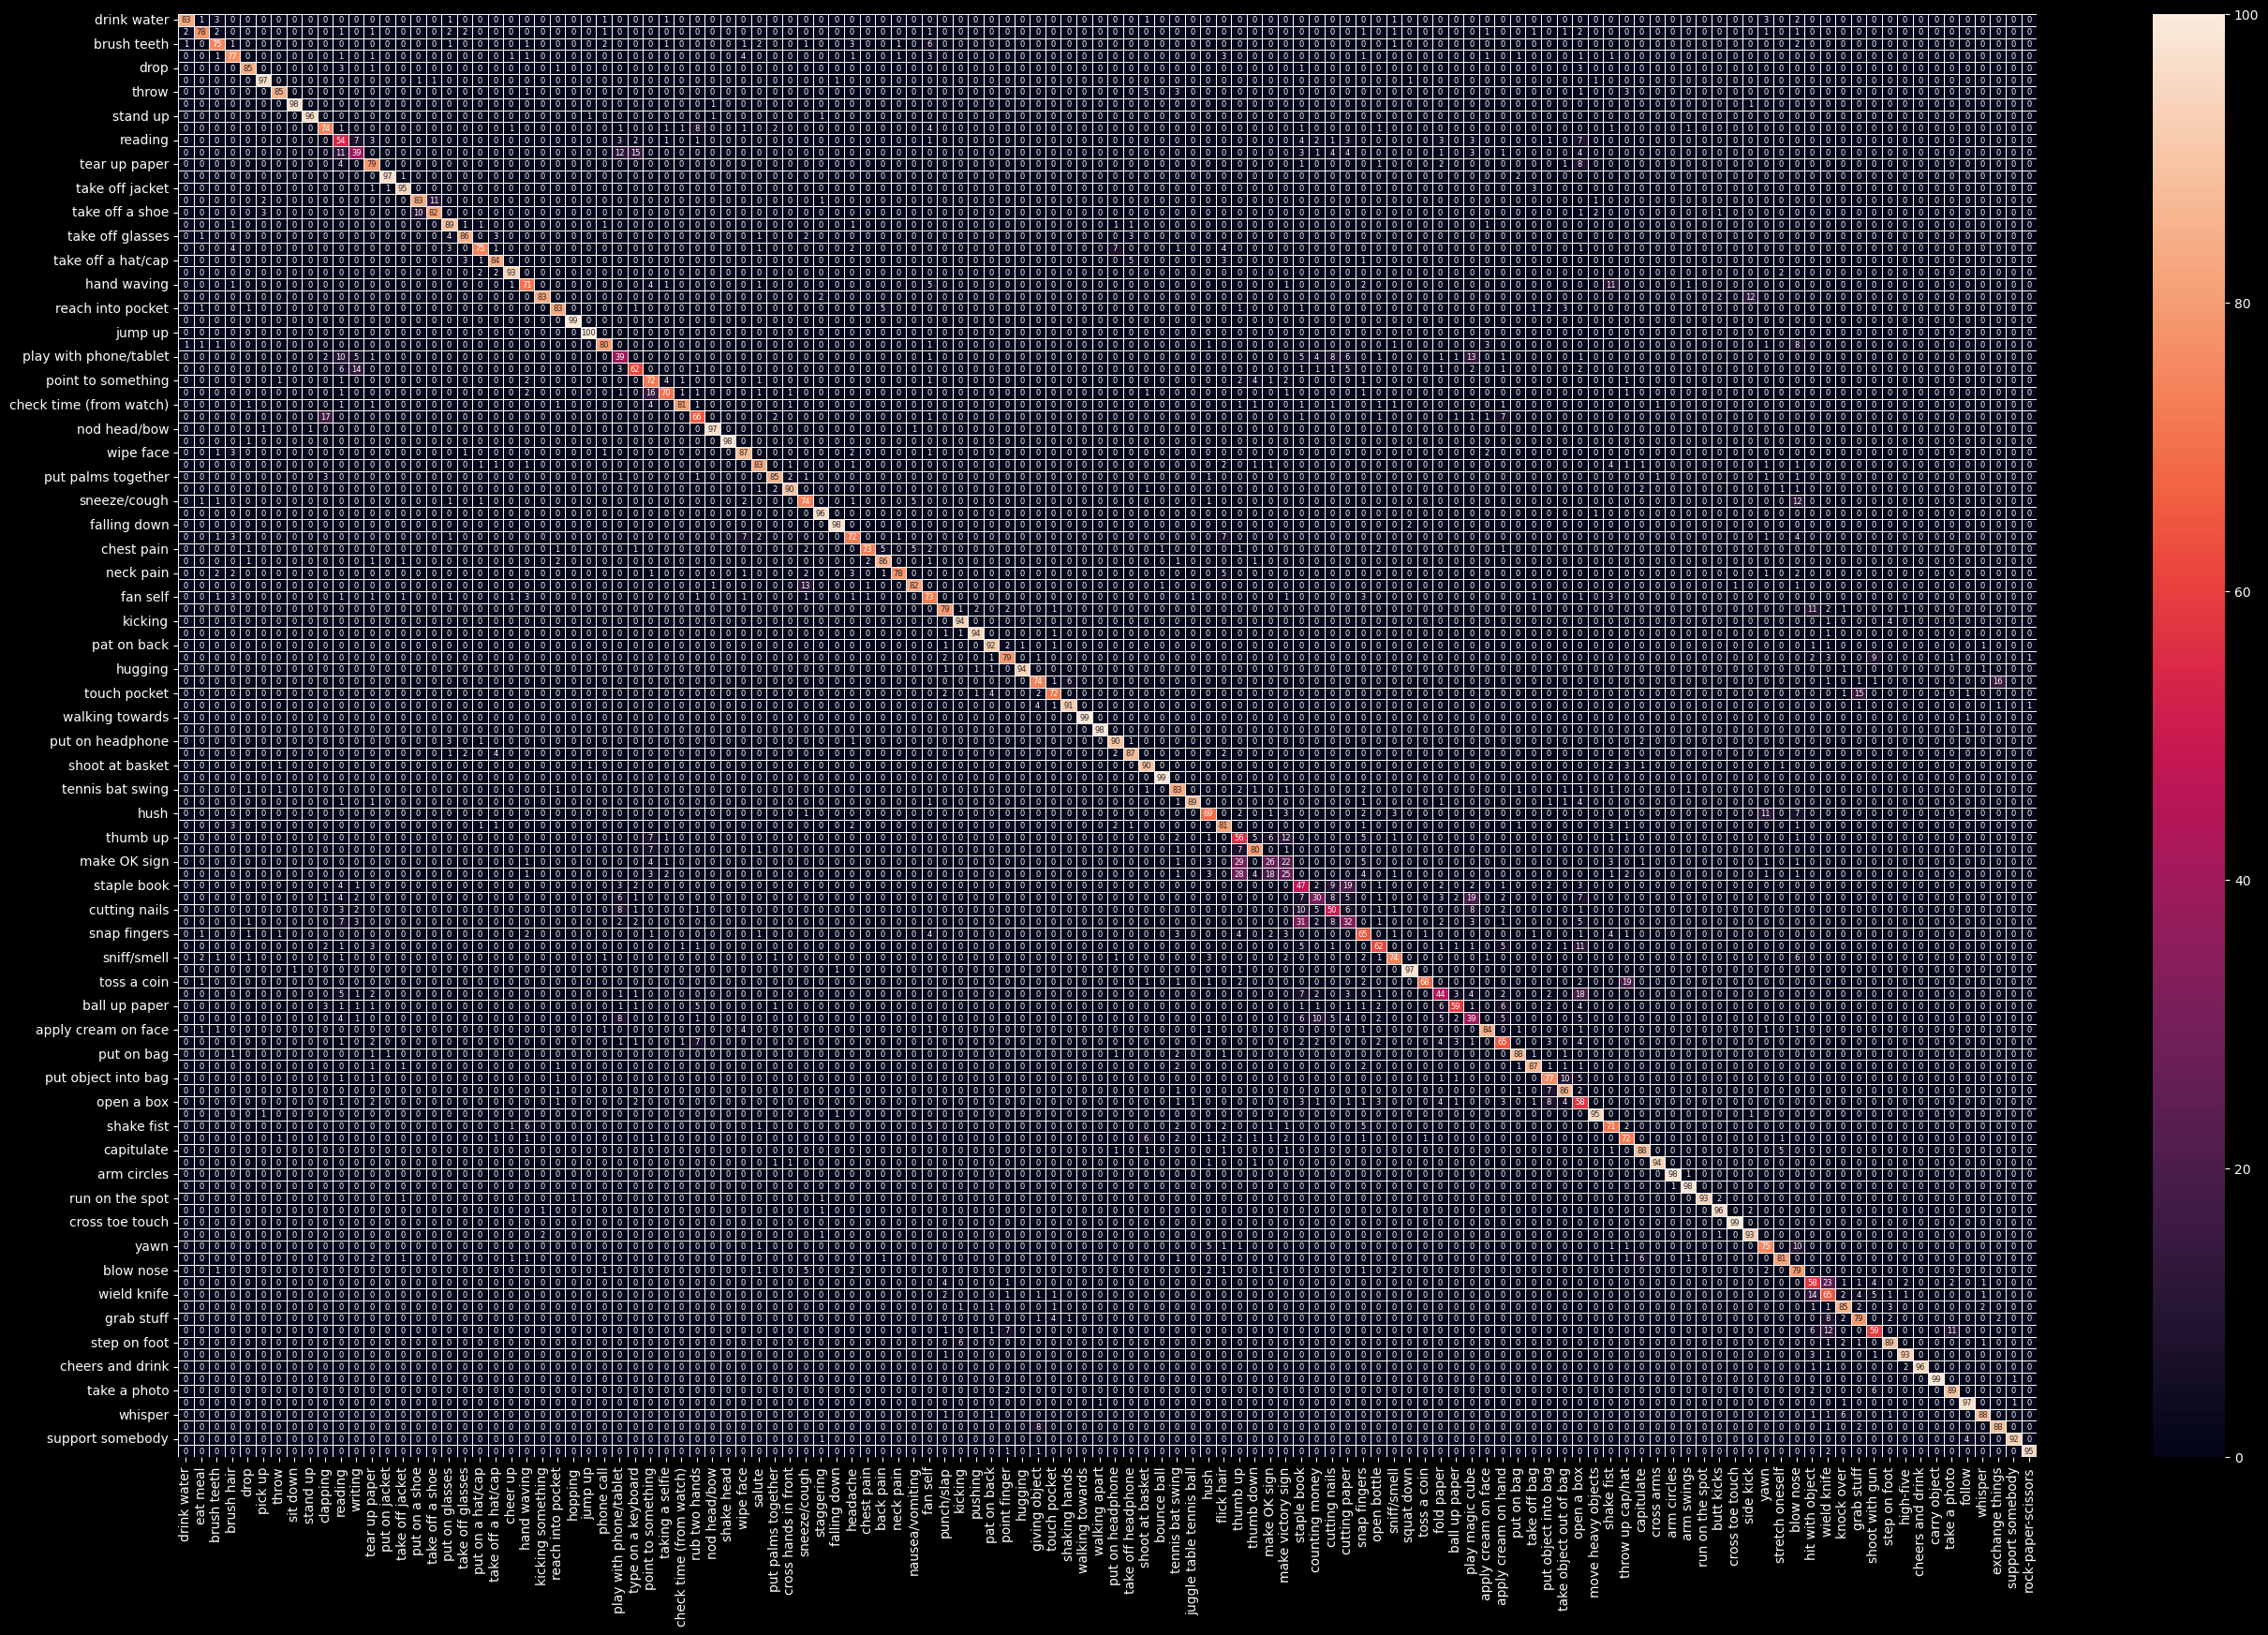

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(32, 20))
sn.heatmap(conf_matrix, annot=True, annot_kws={
           "fontsize": 6}, linewidth=0.5, fmt=".0f")

In [ ]:
from sklearn.metrics import confusion_matrix

preds, labels = getPreds(val_loader)
mat = confusion_matrix(y_true=labels, y_pred=preds)
class_names = list(class_dict.values())[: mat.shape[0]]
conf_matrix = pd.DataFrame(mat)
conf_matrix = 100 * conf_matrix / conf_matrix.sum(axis=1)

<Axes: >

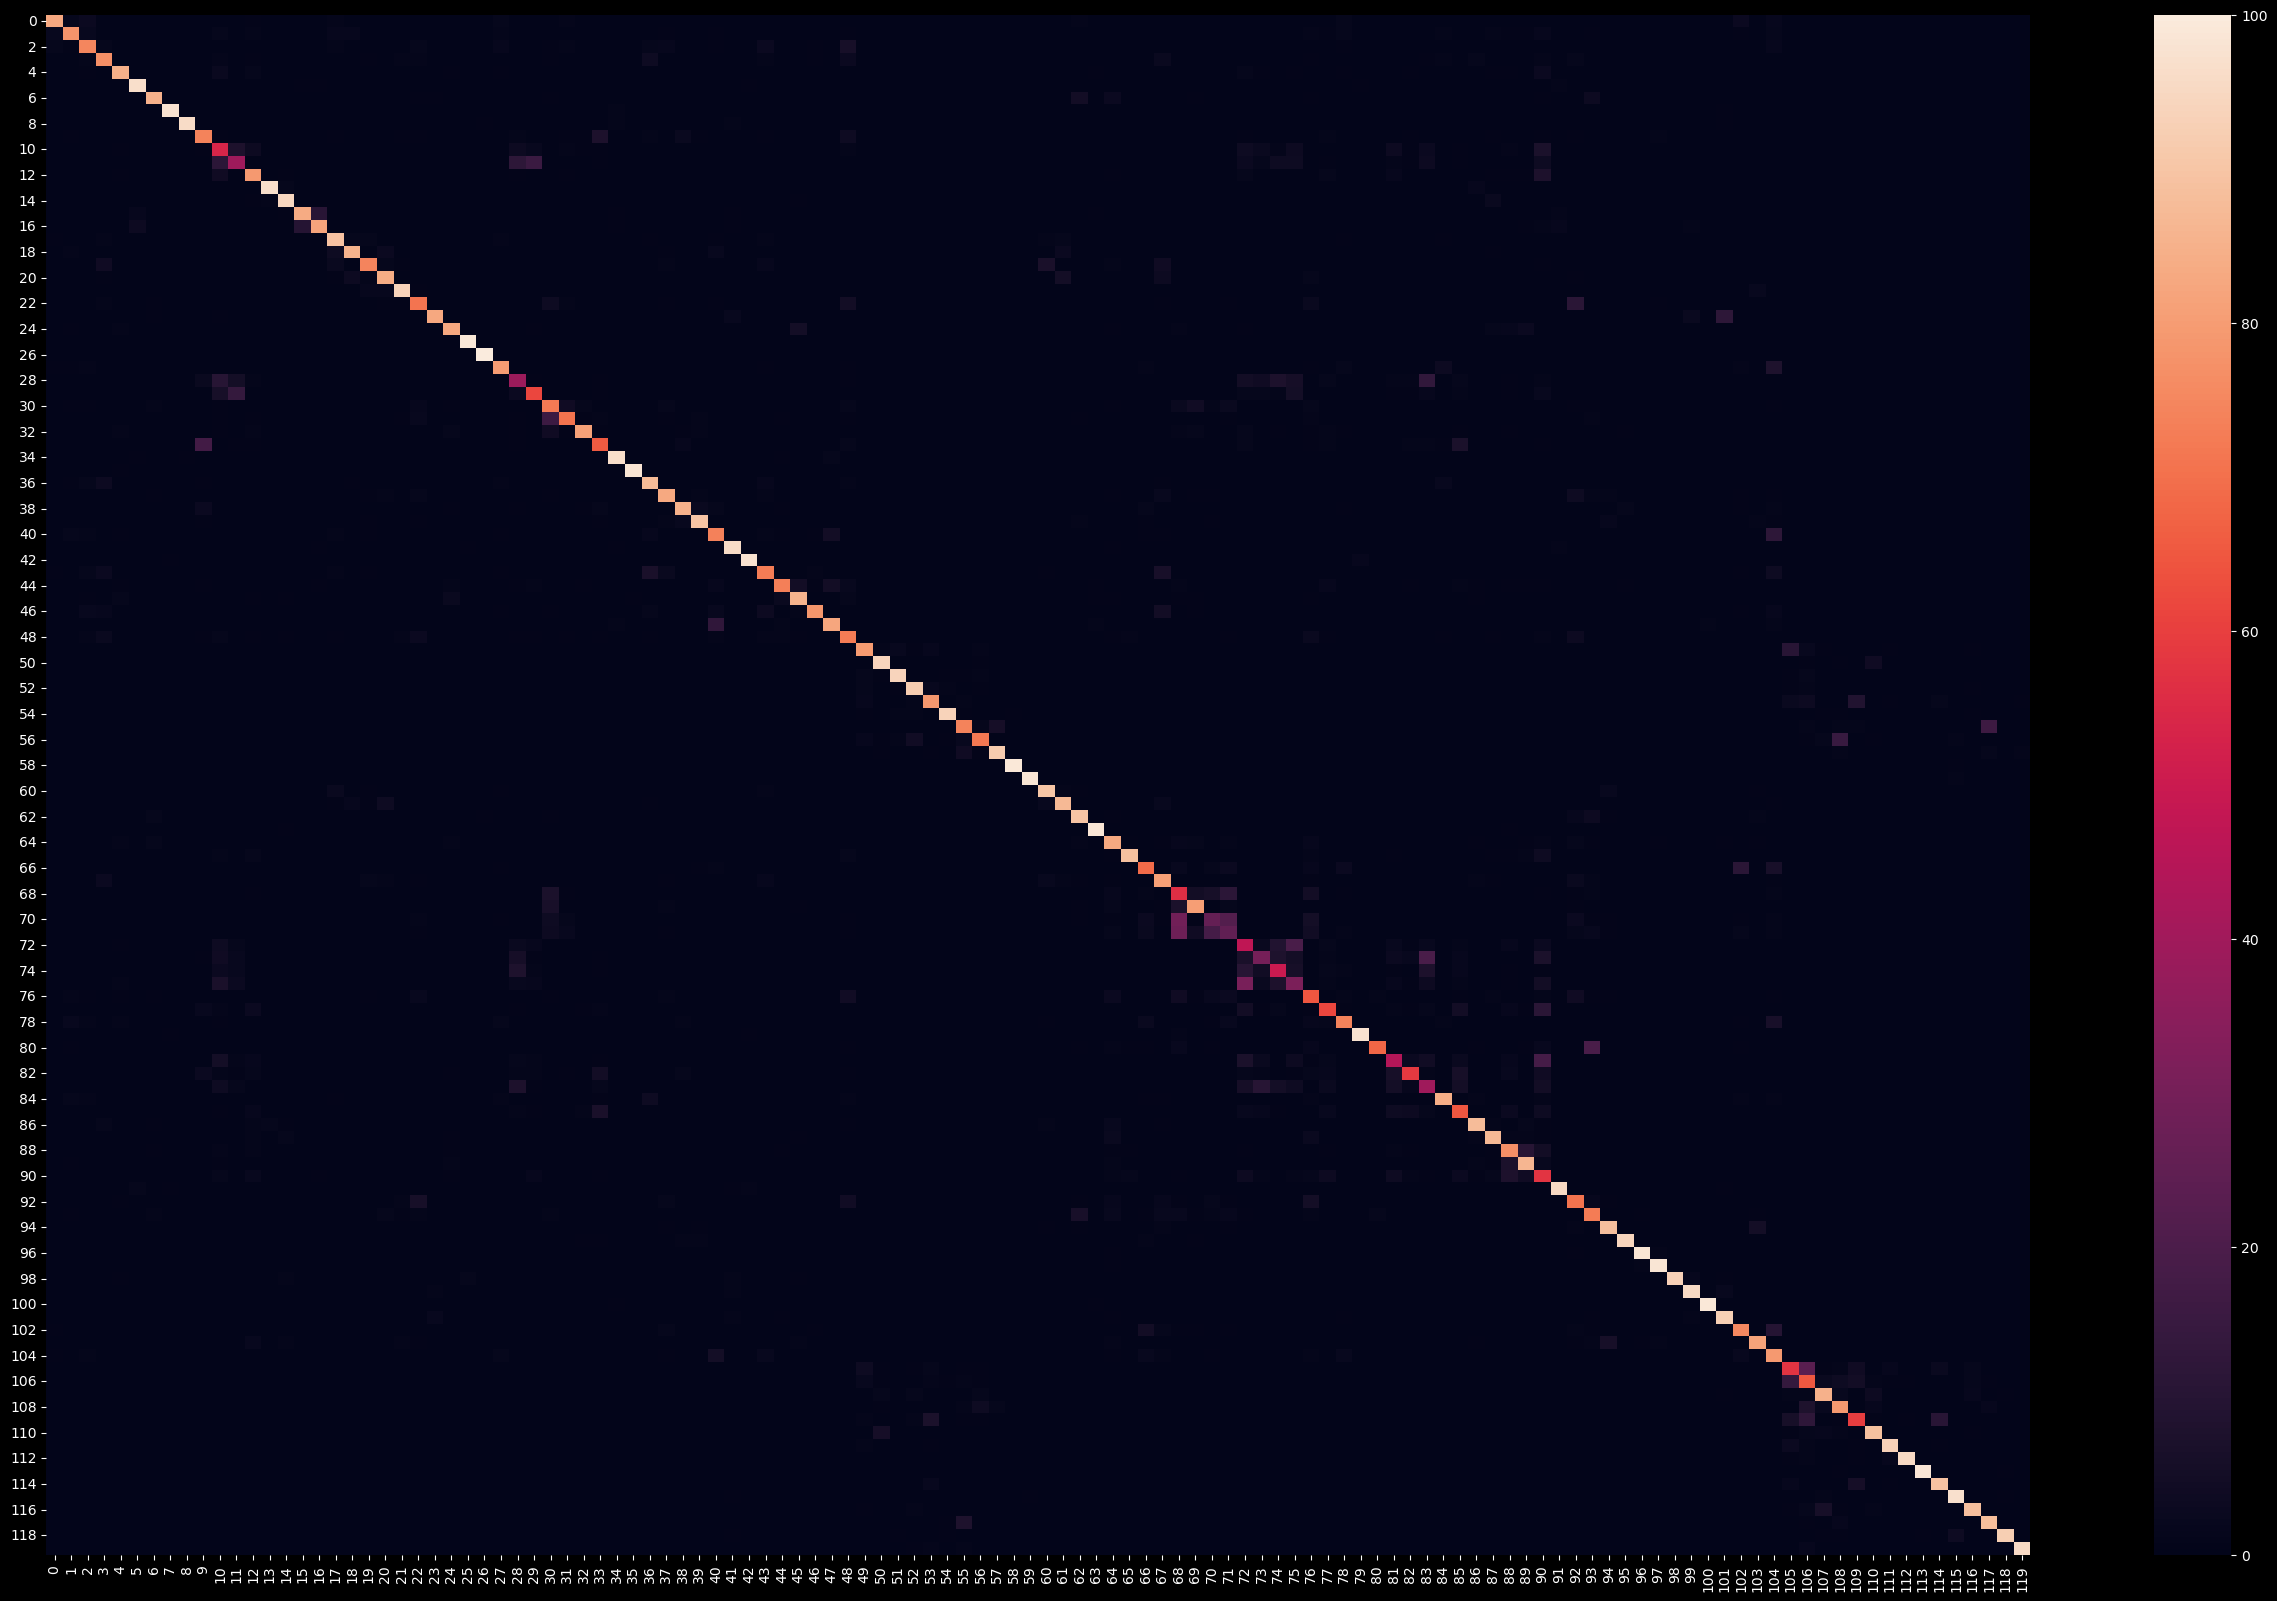

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(32, 20))
sn.heatmap(conf_matrix, annot=False)

In [ ]:
# torch.cuda.empty_cache()

### Best score

#### NTU-60 x-sub
1. 09.10.2023 - **53%**
2. 10.10.2023 - **65.3%**
3. 11.10.2023 - **72.2%**
4. 29.12.2023 - **84.5%**
5. 30.12.2023 - **84.79%**

#### NTU-60 x-view
1. 29.12.2023 - **92.7%**

#### NTU-120 x-sub
1. 29.12.2023 - **74.2%**

#### NTU-120 x-set
1. 29.12.2023 - **75%**

### TODO

*   Kolejność jointów randomowa albo jakiś spot po tym
*   analiza danych, normalizacje
*   wizualizacje

